In [38]:
import kagglehub
import pandas as pd
import numpy as np
from scipy import stats
# Download latest version
path = kagglehub.dataset_download("sohier/calcofi")
print("Path to dataset files:", path)
df = pd.read_csv(f"{path}/bottle.csv")

def remove_outliers_iqr(df, cols):
  Q1 = df[cols].quantile(0.25)
  Q3 = df[cols].quantile(0.75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR
  return df[~((df[cols] < lower) | (df[cols] > upper)).any(axis=1)]


df=df.dropna(subset=["Depthm","T_degC"])
df=df.drop_duplicates(keep='first',subset=["Depthm","T_degC"])
#print(df.count())

shallow_df = df[df['Depthm'] < 50]['T_degC']
deep_df = df[df['Depthm'] > 200]['T_degC']

print(deep_df.head)
df_clean = remove_outliers_iqr(df, ['Depthm', 'T_degC'])

shallow_df = df_clean[df_clean['Depthm'] < 50]['T_degC']
deep_df = df_clean[df_clean['Depthm'] > 200]['T_degC']

shallow_sample = shallow_df.sample(5000, random_state=1)
deep_sample = deep_df.sample(5000, random_state=1)

print(stats.shapiro(shallow_sample))
print(stats.shapiro(deep_sample))

# Leveneov test (jednakost varijanci)
print('levene ',stats.levene(shallow_sample, deep_sample))

print(np.mean(df['Depthm']))
print(np.std(df['Depthm']))
print('Skew: ', df['Depthm'].skew())
print('kurt:',df['Depthm'].kurtosis())

u,p=stats.mannwhitneyu(shallow_sample,deep_sample)
print(u,p)

Path to dataset files: /root/.cache/kagglehub/datasets/sohier/calcofi/versions/2


/tmp/ipython-input-3195452291.py:8: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{path}/bottle.csv")


<bound method NDFrame.head of 17        8.450
18        8.260
19        7.960
20        7.770
21        6.800
          ...  
864852    7.538
864853    6.943
864854    6.694
864855    6.312
864857    5.818
Name: T_degC, Length: 95197, dtype: float64>
ShapiroResult(statistic=np.float64(0.9889804348949329), pvalue=np.float64(2.510088140431303e-19))
ShapiroResult(statistic=np.float64(0.9752043528242175), pvalue=np.float64(1.2283856441875387e-28))
levene  LeveneResult(statistic=np.float64(1897.9822319391112), pvalue=np.float64(0.0))
273.4220720310106
388.11904507005744
Skew:  4.450610459785227
kurt: 30.104429306433754
24807098.5 0.0


Napomena nismo podijelili na dublje i na plice prije nego sto smo se rijesili outliera.

skew pozitivan 4.45 što znaći pozitivna asimetrija tj pomaknuto u lijevo,
kurtosis 30.1 što znači da je spljoštenost leptokurtičnost (krivulja izgleda “visoka i vitka”).

odbacujemo H0 za shapiro zato što podaci nisu normalno distibuirani zato što je pvalue manji od 0.05, ni jedan ni drugi (plici, dublji) nisu normalno rasodjeljeni
za levena takoder odbacujemo H0 zato što je p manji od 0.05
Koristio sam mannwhitney zato što nije normalno distribuirano

mannwhitney test je pokazao da je p 0.0 što je manje od 0.5 te se h0 odbaciju

Broj redaka prije ciscenja: 230373
Broj redaka nakon filtriranja: 221047
Broj redaka nakon IQR filtriranja: 218532
-0.015213281622994282 14.09135987133588 -0.7727558411505526 0.0 2.6729811886332938e-05 0.5971515900322981


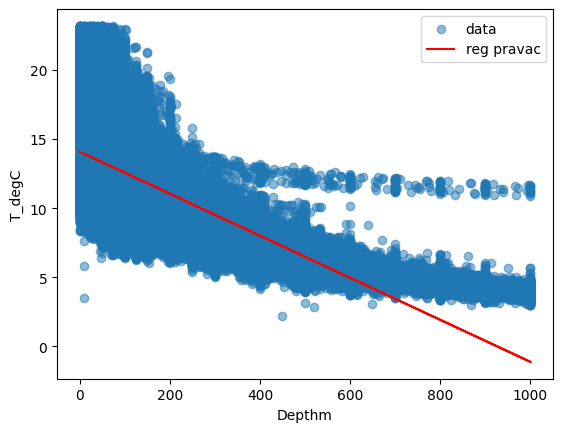

y = 14.09 + -0.0152x, R^2 = 0.597


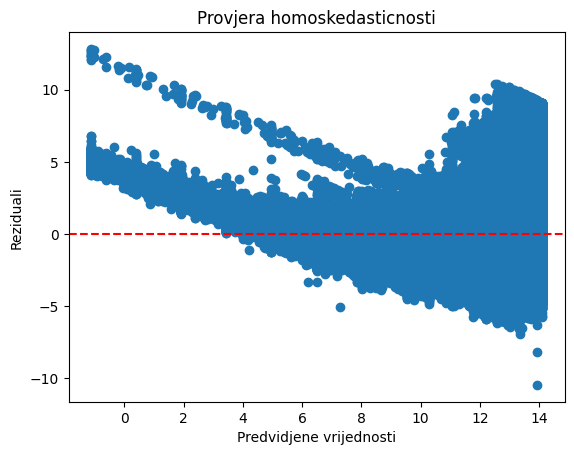

7.105427357601002e-11


In [46]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

df_reg = df[(df['Depthm'].between(0, 1000)) & (df['T_degC'].between(-2, 30)) ].copy()

print("Broj redaka prije ciscenja:", len(df))
print("Broj redaka nakon filtriranja:", len(df_reg))

# 2) Uklanjanje outliera pomocu IQR metode
Q1 = df_reg['T_degC'].quantile(0.25)
Q3 = df_reg['T_degC'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_reg = df_reg[(df_reg['T_degC'] >= lower) & (df_reg['T_degC'] <= upper)]
print("Broj redaka nakon IQR filtriranja:", len(df_reg))

x=df_reg['Depthm']
y=df_reg['T_degC']

slope,intercept,r,p,std_err=linregress(x,y)
print(slope,intercept,r,p,std_err,r*r)

plt.scatter(x,y,alpha=0.5,label="data")
plt.plot(x,intercept+slope*x,color="red",label="reg pravac")
plt.xlabel('Depthm')
plt.ylabel('T_degC')
plt.legend()
plt.show()

print(f"y = {intercept:.2f} + {slope:.4f}x, R^2 = {r**2:.3f}")


y_pred = intercept + slope*x
residuals = y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predvidjene vrijednosti")
plt.ylabel("Reziduali")
plt.title("Provjera homoskedasticnosti")
plt.show()

print(residuals.sum())

vidimo da sa povećanjem dubine temperatura opada tj ako je plitko vidimo da je toplije a nakon određene temperatura neovisno o dubini temperatura se na smanjuje

slope je negativan što je očekivano, intercept je 14.09, koeficijenta korelacije r je -0,77 znaći da nije najbolja korelacija tj podaci ne prate linearnu regresiju, determinacije ( R**2 ) 0.597 , p vrijednost 0.0 i standard error je  2.6729811886332938e-05 što znaći da je jako mala greška

y = 14.09 + -0.0152x, R^2 = 0.597


postoje razlika između stvarnih vrijednosti i predviđenih vrijednosti (residuals), ukupni residual je 7.105427357601002e-11, što je jako malo

pre:
-0.2445505903114016
-0.020708498603080105
post:
-0.19646070213743871
-0.40384254329319225
ShapiroResult(statistic=np.float64(0.9679852884200666), pvalue=np.float64(0.11620561928825013))
ShapiroResult(statistic=np.float64(0.9842729324869284), pvalue=np.float64(0.6323036477521675))
-3.016041066827344 0.003136869181531365


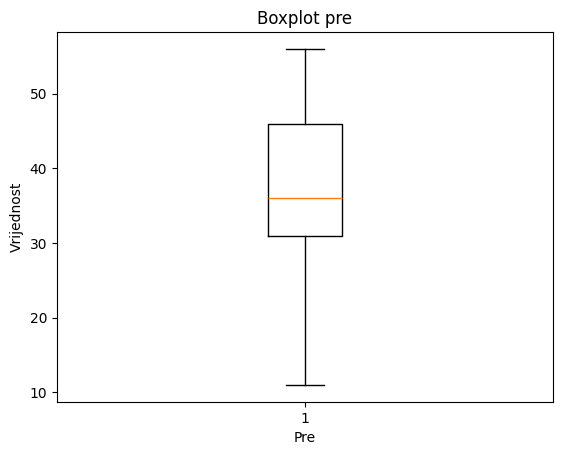

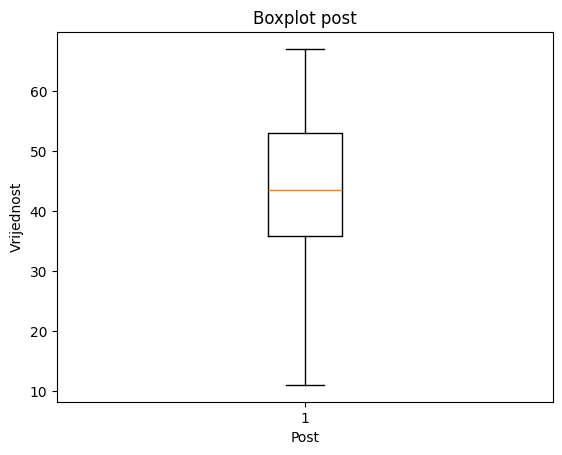

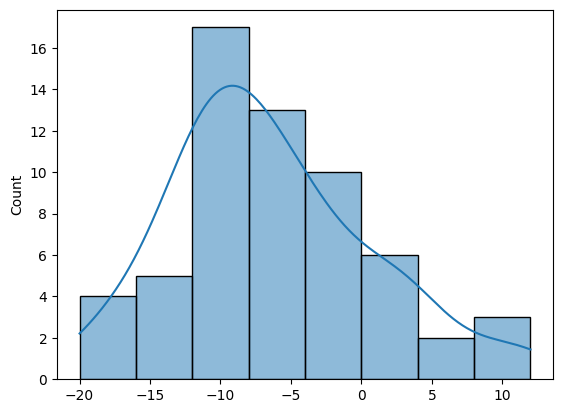

T-statistic: -7.091086459674953
P-value: 1.8967651553056133e-09


In [51]:
import seaborn as sns
data=pd.read_excel('ispitanici.xlsx')

data.describe()
print("pre:")

print(data['Pre'].skew())
print(data['Pre'].kurtosis())

print("post:")

print(data['Post'].skew())
print(data['Post'].kurtosis())


print(stats.shapiro(data['Pre']))
print(stats.shapiro(data['Post']))

t,p=stats.ttest_ind(data['Pre'],data['Post'])
print(t,p)

plt.boxplot(data["Pre"])
plt.xlabel("Pre")
plt.ylabel("Vrijednost")
plt.title("Boxplot pre")
plt.show()

plt.boxplot(data["Post"])
plt.xlabel("Post")
plt.ylabel("Vrijednost")
plt.title("Boxplot post")
plt.show()

sns.histplot(data['Pre']-data['Post'],kde=True)
plt.show()


t_statistic_scipy, p_value_scipy = stats.ttest_rel(data['Pre'],data['Post'])
print("T-statistic:", t_statistic_scipy)
print("P-value:", p_value_scipy)

Koristit će mo parni test zato što je P-vrijednost shapira u oba slučaja veća od 0.05( 0.116 za pre i  0.63 za post )
Vidimo na boxplotu da nema outlayeara.

T-statistic: -7.091086459674953
P-value: 1.8967651553056133e-09

Vrijednost P-value: paired t testa je manja od 0.05 postoji značajna razlika između pre i post vrijednosti.